In [ ]:
'''

'''

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


%matplotlib inline

# read zone lookup table
zones = 'taxi_zone_lookup.csv'
zonesLookup = pd.read_csv(zones)

def csv_df(url):
    chunksize = 50000
    df = None
    for dfchunk in pd.read_csv(url, chunksize=chunksize, header=0, iterator=True,
        usecols=["tpep_pickup_datetime", "tpep_dropoff_datetime", 
                 "passenger_count","trip_distance","PULocationID","DOLocationID",
                 "payment_type","fare_amount","total_amount"],
        parse_dates=["tpep_pickup_datetime","tpep_dropoff_datetime"]):
        if df is None:
            df = dfchunk.copy()
        else:
            df = df.append(dfchunk)
    # Merge the data with taxi zones table (taking only data we need for the QR#2)
    df_= df.merge(zonesLookup[['LocationID','Borough']],how='inner', left_on='PULocationID', right_on='LocationID')

    return(df_)

# read taxi data for Jan 2018
data_jan = csv_df('yellow_tripdata_2018-01.csv')

# it takes ?? seconds for Jan data
#data_jan.head()

In [ ]:
'''
    OPTIMIZING DATAFRAME STORAGE IN MEMORY
    Dealing with large size of data files, we thought about some points in order to faciltate the processing:
    1 - Knowing our resources of processing, capability of the CPU and the memory we have.
    2 - The size of csv files.
    3 - The size of the data frames after importing from csv files.
    
    Having 8GB of RAM with not-bad processing power, we have to adapt our data and the method of data handling with those resources.
    After importing the first csv file (Jan 2018) sized 772MB we checked the memory allocation of the data frame, and it was 1.3G
    so logically importing all files to memory will be a problem, so either we have to process each file and get only data we need
    for our analyze and keep it in smaller and simpler csv file or light database system, or if we managed to decrease the size of the 
    dataframe we are working on to some size enough to fit all files in memory without affecting the performance.
    
    
    
'''

In [20]:
# We are going to check the stroage of the dataframe in memory and the data types of the columns:
data_jan.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8759874 entries, 0 to 8759873
Data columns (total 11 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          int64
trip_distance            float64
PULocationID             int64
DOLocationID             int64
payment_type             int64
fare_amount              float64
total_amount             float64
LocationID               int64
Borough                  object
dtypes: datetime64[ns](2), float64(3), int64(5), object(1)
memory usage: 1.3 GB


In [21]:
data_jan.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,LocationID
count,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06,8.759874e+06
mean,1.606855e+00,2.804001e+00,1.644585e+02,1.627269e+02,1.310611e+00,1.224434e+01,1.549098e+01,1.644585e+02
std,1.258464e+00,6.412346e+01,6.636021e+01,7.031164e+01,4.817818e-01,1.168321e+01,1.419540e+01,6.636021e+01
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.500000e+02,-4.503000e+02,1.000000e+00
25%,1.000000e+00,9.100000e-01,1.160000e+02,1.130000e+02,1.000000e+00,6.000000e+00,8.300000e+00,1.160000e+02
50%,1.000000e+00,1.550000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,1.130000e+01,1.620000e+02
75%,2.000000e+00,2.840000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,1.662000e+01,2.340000e+02
max,9.000000e+00,1.894838e+05,2.650000e+02,2.650000e+02,4.000000e+00,8.016000e+03,8.016800e+03,2.650000e+02


In [ ]:
'''
    1- We notice that we can modify the data type in order to get smaller allocation in memeory:
        . For integers, we dont have negative values, so we convert them to 'unsigned'
        . For floats, we downcast from 64 to 32
        . For string, we converted to category type
    2 - We noticed some wierd values, which should be removed:
        . Negative or zero values in passenger counts, trip distance and fare amount (Must be done before downcasting to unsigned)
        . Some trips have departure time before 1 Jan 2018.
        . Some trips have drop off time equal or before pick up time.
        
    So we created a function to do the above optimization, thus we apply to each month data later on.
'''

In [27]:

def df_optimize(df):
    
    df = df[df.passenger_count>0]
    df = df[df.trip_distance>0]
    df = df[df.tpep_pickup_datetime<df.tpep_dropoff_datetime]
    df = df[df.tpep_pickup_datetime>datetime(2017,12,31)]
    df = df[df.fare_amount>0]
    
    data_int = df.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='unsigned')
    data_float = df.select_dtypes(include=['float']).apply(pd.to_numeric,downcast='float')
    data_obj = df.select_dtypes(include=['object']).astype('category')
    data_optimized = df.copy()
    data_optimized[data_int.columns] = data_int
    data_optimized[data_float.columns] = data_float
    data_optimized[data_obj.columns] = data_obj
    
    return(data_optimized)

data_jan_optimized = df_optimize(data_jan)
#data_jan_optimized.head()

In [28]:
data_jan_optimized.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8641187 entries, 0 to 8759872
Data columns (total 11 columns):
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count          uint8
trip_distance            float32
PULocationID             uint16
DOLocationID             uint16
payment_type             uint8
fare_amount              float32
total_amount             float32
LocationID               uint16
Borough                  category
dtypes: category(1), datetime64[ns](2), float32(3), uint16(3), uint8(2)
memory usage: 370.8 MB


In [11]:
'''
    AS we notice, we decreased the memory usage from 1.3GB to 370.8 MB (27.8% from original usage)
'''

In [29]:
# Removing the old dataframes
del data_jan

In [15]:
# Loading and processing other months data, using the above two functions
# After optimizing the storage, we can handle all data frames in memory

In [30]:
data_feb_optimized = df_optimize(csv_df('yellow_tripdata_2018-02.csv'))

# about 2 min 50 sec

In [31]:
data_mar_optimized = df_optimize(csv_df('yellow_tripdata_2018-03.csv'))
data_apr_optimized = df_optimize(csv_df('yellow_tripdata_2018-04.csv'))
data_may_optimized = df_optimize(csv_df('yellow_tripdata_2018-05.csv'))
data_jun_optimized = df_optimize(csv_df('yellow_tripdata_2018-06.csv'))


In [18]:
'''
     RQ1
     - First we create a plot showing the number of daily trips fro each month. For NY and then for each borough
     - Then we calculate the daily average for each month
'''

In [ ]:
# For each Question, we will create temporary Dataframe using only the columns we need from the origianl ones, and delete when done of them

In [63]:
# we will create a function in order to use on the other manoths data
def rq1_process(df):
    # We create empty Dataframe, with two column, one for pick up time, and the other for the borough
    rq1_ = pd.DataFrame(columns=['PU_day','Borough'])
    # From pickup time we only use the day
    rq1_['PU_day'] = df['tpep_pickup_datetime'].apply(lambda x: pd.to_datetime(x).day)
    rq1_['Borough'] = df['Borough']
    return (rq1_)
    
# We start to analys January data
rq1_jan = rq1_process(data_jan_optimized)

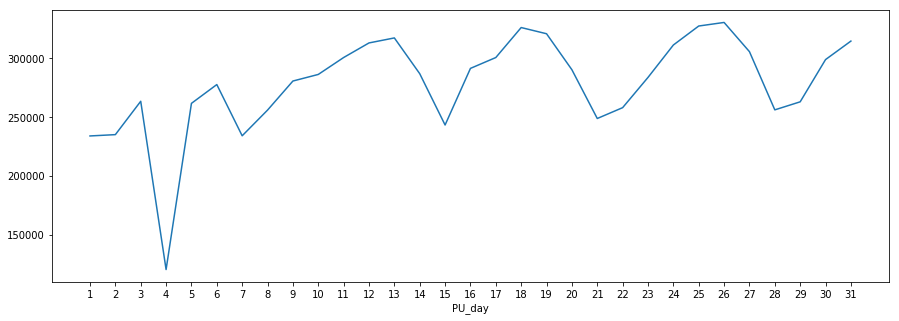

In [64]:
# we create a function to plot all NY data
def rq1_plot_ny(df, days):
    # To show the daily trips in Jan (in NY), we group the rq1_jan by day values
    df[['PU_day','Borough']].groupby('PU_day').size()
    # and then we plot it
    fig, ax = plt.subplots(figsize=(15,5))
    # Modify the x-axis to show numbers between 1-31
    plt.xticks(list(range(1,days+1)))
    df[['PU_day','Borough']].groupby('PU_day').size().plot(ax=ax,kind="line")
    return

# plotting Jan data
rq1_plot_ny(rq1_jan, 31)

In [ ]:
'''
    Visualizing the number of daily trips in Jan 2018 in NY, we notice:
    - the peak of number of trips is on 26, 19 and 12 (Fridays)
    - the lowest days in number of trips are generally Sun and Mon
    - (*) We notice a weird drop down on 4th Jan, tried to google anout it with no result.
'''

In [65]:
# Now we have to check for each borough, we also create function for plotting
# the function will return the daily average of trips 
def rq1_plot_boroughs(df):
    # Group by day and Borough and calculate the number of daily trips for each borough
    rq1_plot_ = df[['PU_day','Borough']].groupby(['PU_day','Borough'])['PU_day'].size().unstack()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_axes([0.1, 2.1, 0.8, 0.4])
    ax2 = fig.add_axes([0.1, 1.7, 0.8, 0.4])
    ax3 = fig.add_axes([0.1, 1.3, 0.8, 0.4])
    ax4 = fig.add_axes([0.1, 0.9, 0.8, 0.4])
    ax5 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
    ax6 = fig.add_axes([0.1, 0.1, 0.8, 0.4])


    ax1.plot(rq1_plot_.iloc[:,0], label="Bronx")
    ax2.plot(rq1_plot_.iloc[:,1], label="Brooklyn")
    ax3.plot(rq1_plot_.iloc[:,2], label="EWR")
    ax4.plot(rq1_plot_.iloc[:,3], label="Manhattan")
    ax5.plot(rq1_plot_.iloc[:,4], label="Queens")
    ax6.plot(rq1_plot_.iloc[:,5], label="Staten Island")

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper right")
    ax5.legend(loc="upper right")
    ax6.legend(loc="upper right")
    
    return(rq1_plot_.mean(axis=0))



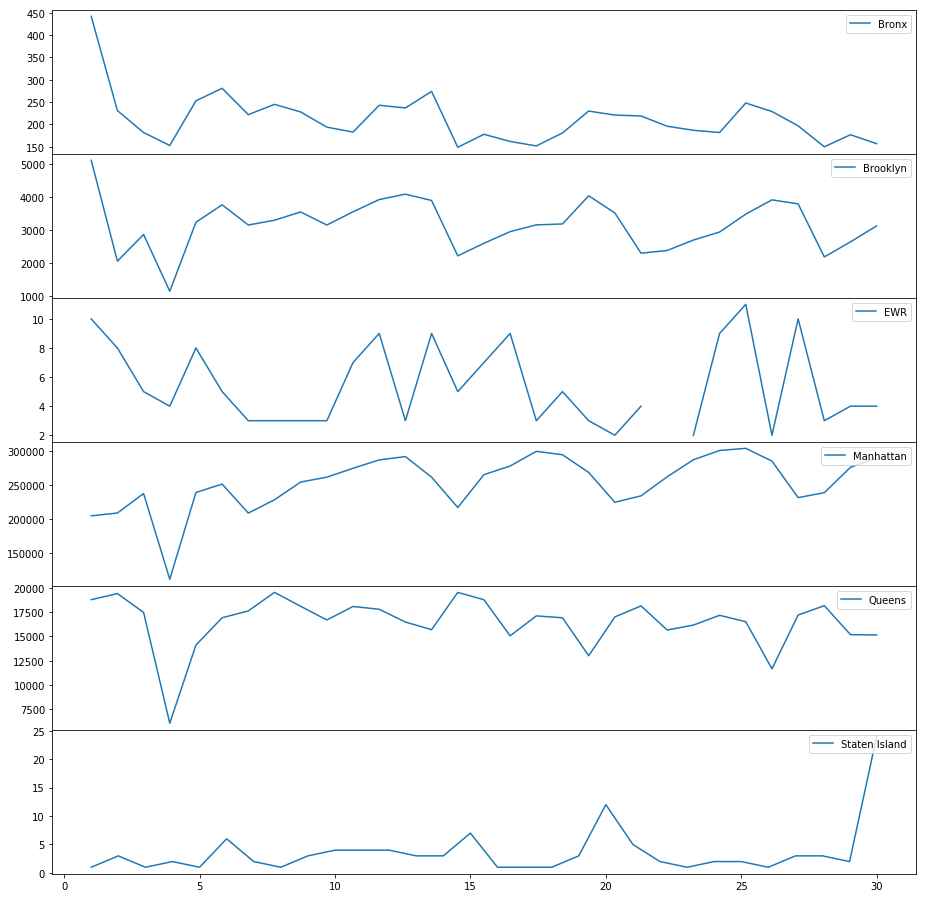

In [66]:
# plotting Jan data for each borough, and getting the daily average
rq1_jan_average = rq1_plot_boroughs(rq1_jan)

In [ ]:
'''
    Data in some boroughs (EWR, Staten Island) are too small comparing to others
    The low number of trips on 4th Jan is clear.
'''

In [67]:
# Now we calculatethe daily average for Jan, and keep it to compare with other months:
rq1_jan_average

Borough
Bronx               212.354839
Brooklyn           3152.096774
EWR                   5.433333
Manhattan        254222.000000
Queens            16500.580645
Staten Island         3.600000
Unknown            4652.193548
dtype: float64

In [ ]:
# remove RQ1 Jan data from memory
del rq1_jan

In [ ]:
'''
    By doing the same processing on other months data, we will get daily average for each month
    we will use the functions we created.
    no need to plot for each month, we will only get the daily average for each month and combine all
'''

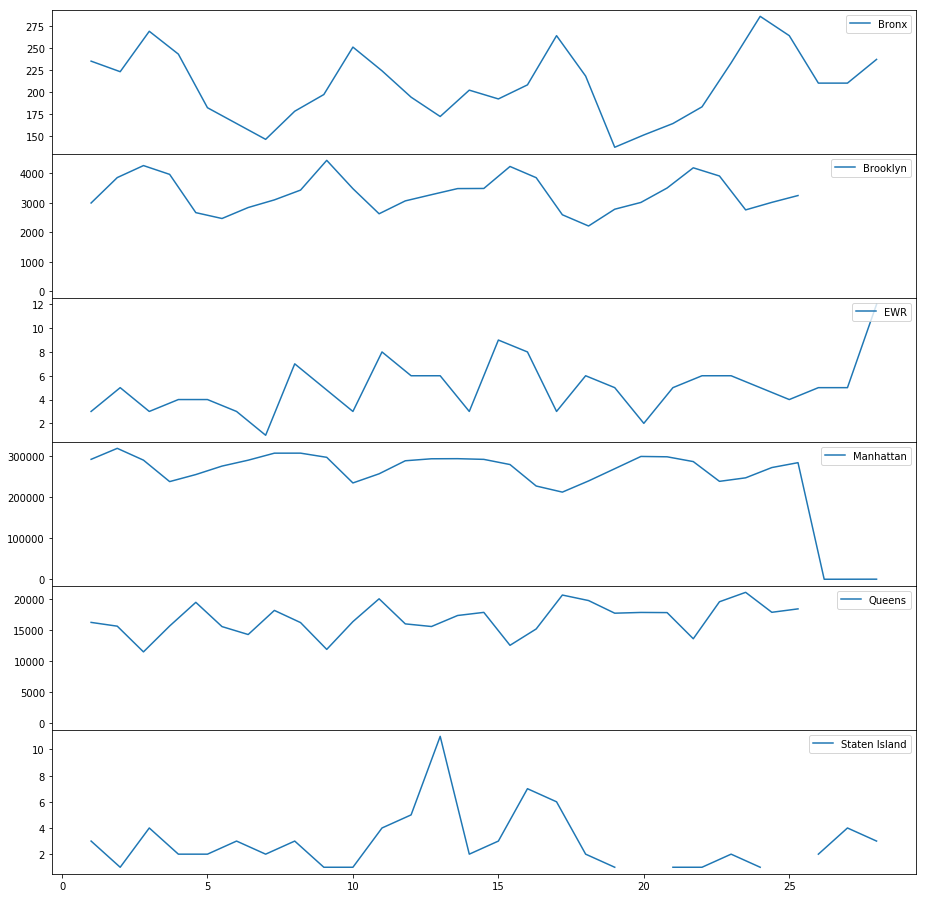

In [68]:
rq1_feb_average = rq1_plot_boroughs(rq1_process(data_feb_optimized))

In [ ]:
'''
    We can weird drop in number of trips in Manhattan from 27 to end of March
'''

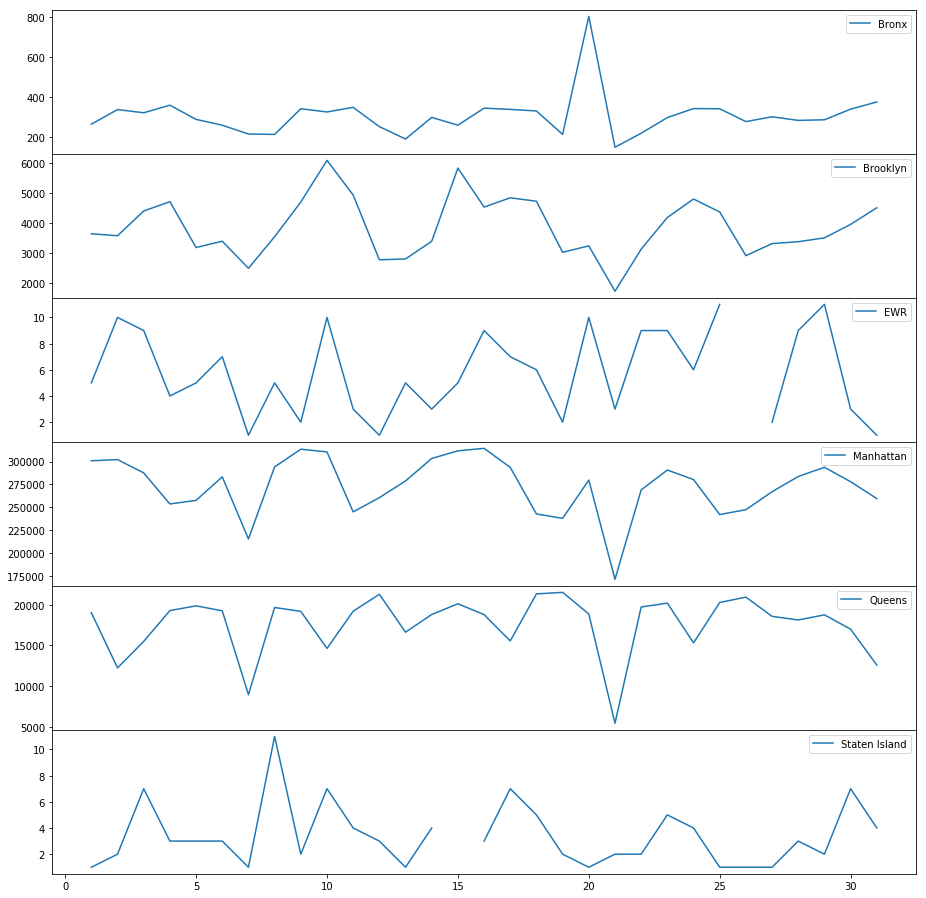

In [69]:
rq1_mar_average = rq1_plot_boroughs(rq1_process(data_mar_optimized))

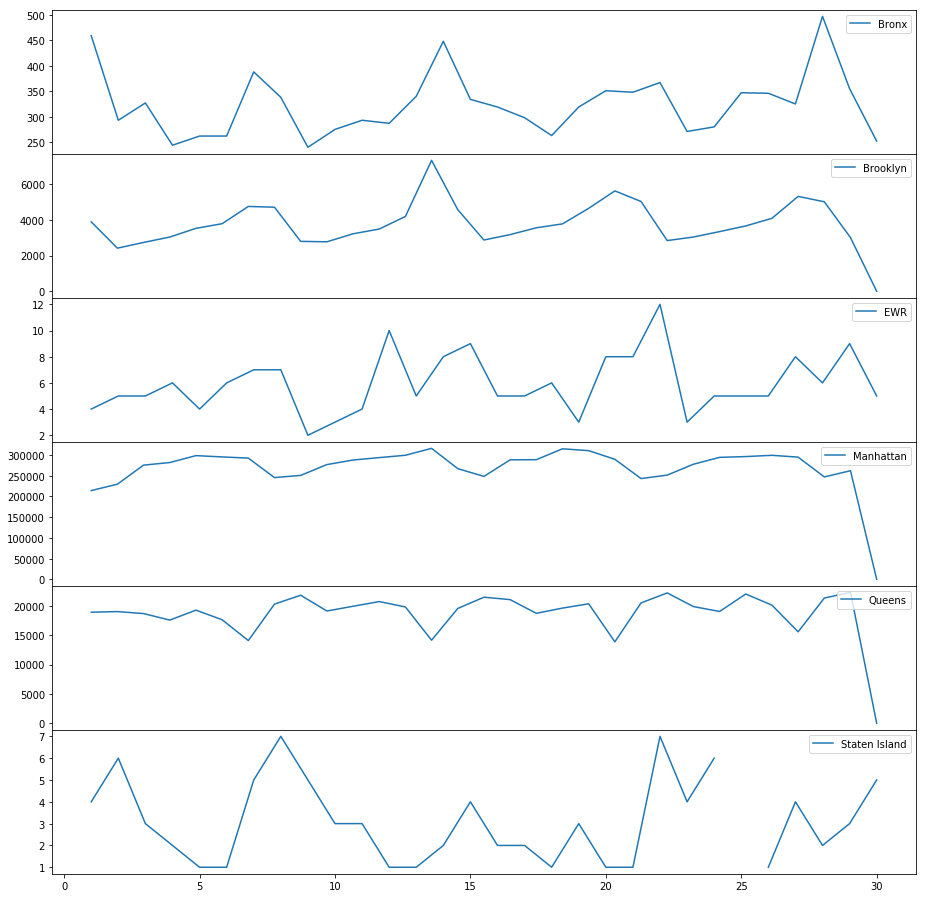

In [70]:
rq1_apr_average = rq1_plot_boroughs(rq1_process(data_apr_optimized))

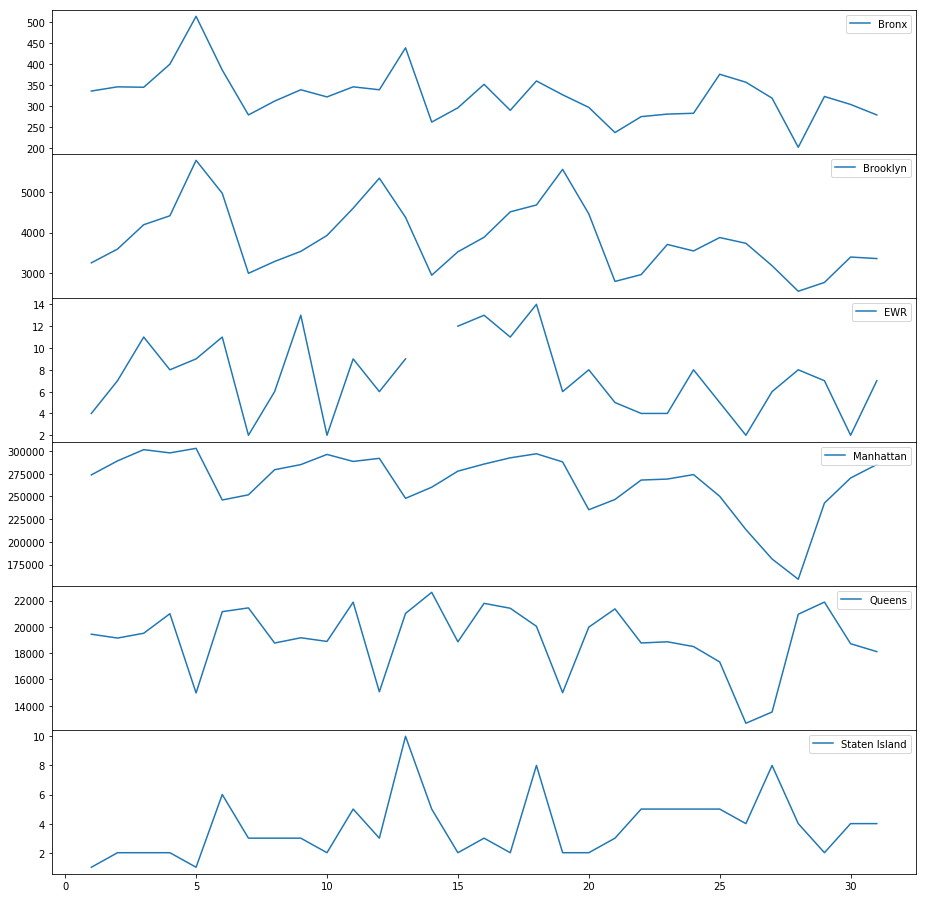

In [71]:
rq1_may_average = rq1_plot_boroughs(rq1_process(data_may_optimized))

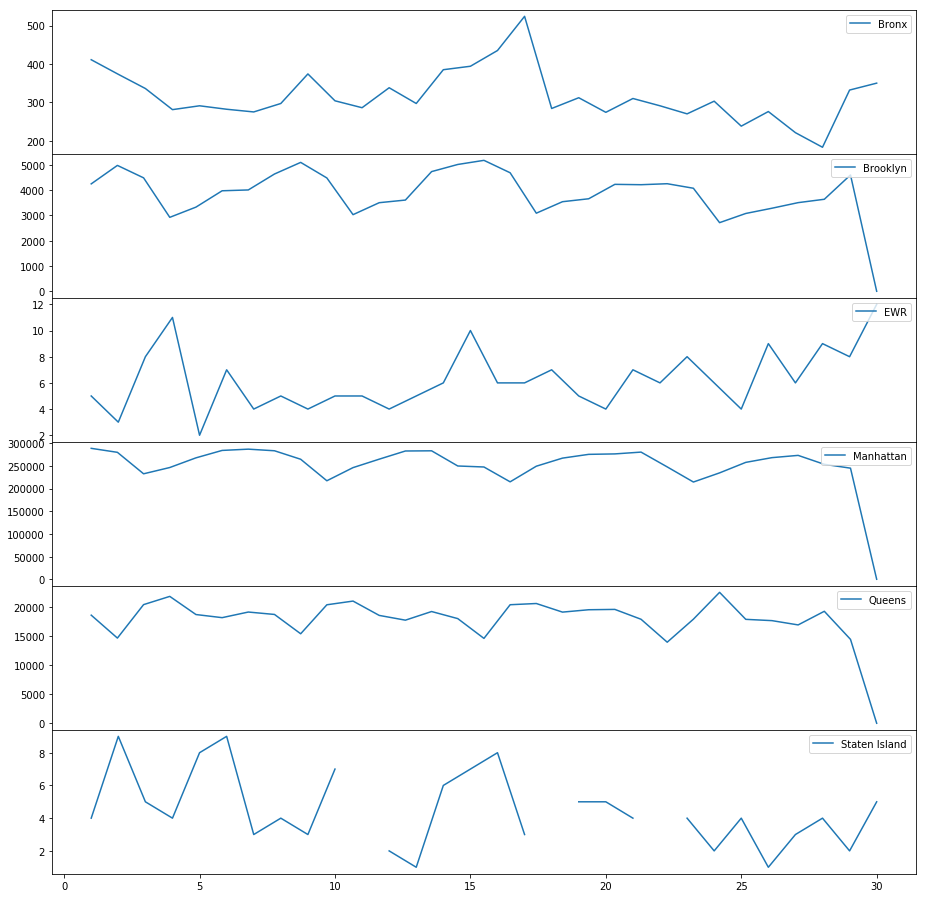

In [72]:
rq1_jun_average = rq1_plot_boroughs(rq1_process(data_jun_optimized))

In [73]:
# We combine the daily average for all months:
rq1_18_average = pd.concat([rq1_jan_average,rq1_feb_average,rq1_mar_average,rq1_apr_average,rq1_may_average,rq1_jun_average], axis=1)
rq1_18_average.columns=['Jan','Feb','Mar','Apr','May','Jun']
rq1_18_average

,Jan,Feb,Mar,Apr,May,Jun
Borough,,,,,,
Bronx,212.354839,208.464286,307.612903,324.266667,326.548387,317.566667
Brooklyn,3152.096774,3192.689655,3864.096774,3743.935484,3860.838710,3865.935484
EWR,5.433333,5.071429,5.766667,5.933333,7.300000,6.233333
Manhattan,254222.000000,256220.700000,273284.774194,268748.774194,266164.677419,251018.096774
Queens,16500.580645,16200.482759,17633.258065,18652.161290,19090.838710,17881.806452
Staten Island,3.600000,2.961538,3.400000,3.103448,3.741935,4.518519
Unknown,4652.193548,4423.857143,4721.000000,4353.354839,3705.806452,3626.516129


In [93]:
rq1_18_average.sum(axis=0)

Jan    278748.259140
Feb    280254.226809
Mar    299819.908602
Apr    295831.529255
May    293159.751613
Jun    276720.673357
dtype: float64

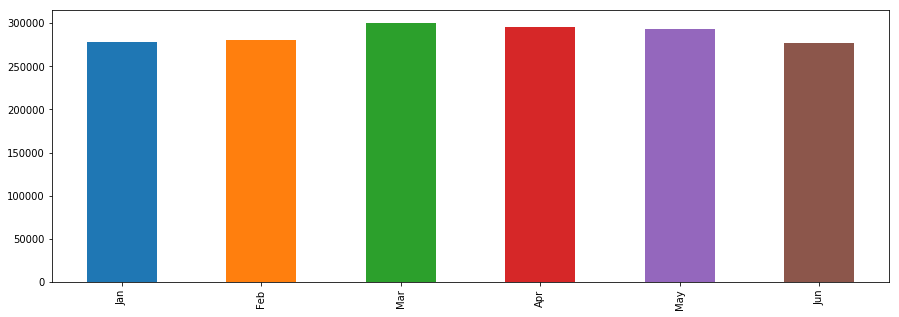

In [92]:
fig, ax = plt.subplots(figsize=(15,5))
# Modify the x-axis to show numbers between 0-23
#plt.xticks([['Jan','Feb','Mar','Apr','May','Jun']])
rq1_18_average.sum(axis=0).plot(ax=ax,kind='bar')

In [ ]:
'''
    We notice that March is the month when the taxi service is used more, wit highest daily average.
'''

In [95]:
'''
    As we finished the first Question, we are going to remove its variables to free some memory
    But we will keep the optimized dataframe for each month.
'''
del rq1_18_average
del rq1_jan_average
del rq1_feb_average
del rq1_mar_average
del rq1_apr_average
del rq1_may_average
del rq1_jun_average
    


In [ ]:
'''
    RQ2:
    We will find the time slot with most passenger:
    We are going to divide the day into 24 slots, one for each hour, and calculate the number of passengers,
    by summing the trips multiplied by the passenger counts for each trip.
    and then find the average of passenger for each slot during the Jan, and then during the whole period.
'''

In [110]:
# the below function takes the data of one month and return the average of passengers by slots
def rq2_process(df):
    rq2_ = pd.DataFrame(columns=['PU_hour','passenger_count','Borough'])
    # From pickup time we only use the hour
    rq2_['PU_hour'] = df['tpep_pickup_datetime'].apply(lambda x: pd.to_datetime(x).hour)
    rq2_['passenger_count'] = df['passenger_count']
    rq2_['Borough'] = df['Borough']

    return (rq2_)

def rq2_plot_ny(df):
    #df[['PU_hour','passenger_count']].groupby('PU_hour').sum()
    fig, ax = plt.subplots(figsize=(15,5))
    # Modify the x-axis to show numbers between 0-23
    plt.xticks(list(range(24)))
    df[['PU_hour','passenger_count']].groupby('PU_hour').sum().plot(ax=ax,kind="bar")
    return ()
    
def rq2_plot_boroughs(df):
    # Modify the x-axis to show numbers between 0-23
    #plt.xticks(list(range(24)))
    
    # Group by day and Borough and calculate the number of daily trips for each borough
    rq2_plot_ = df[['PU_hour','passenger_count','Borough']].groupby(['PU_hour','Borough'])['PU_hour'].size().unstack()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_axes([0.1, 2.1, 0.8, 0.4])
    ax2 = fig.add_axes([0.1, 1.7, 0.8, 0.4])
    ax3 = fig.add_axes([0.1, 1.3, 0.8, 0.4])
    ax4 = fig.add_axes([0.1, 0.9, 0.8, 0.4])
    ax5 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
    ax6 = fig.add_axes([0.1, 0.1, 0.8, 0.4])

    rq2_plot_.iloc[:,0].plot(ax=ax1,kind="bar", label="Bronx")
    rq2_plot_.iloc[:,1].plot(ax=ax2,kind="bar", label="Brookly")
    rq2_plot_.iloc[:,2].plot(ax=ax3,kind="bar", label="EWR")
    rq2_plot_.iloc[:,3].plot(ax=ax4,kind="bar", label="Manhattan")
    rq2_plot_.iloc[:,4].plot(ax=ax5,kind="bar", label="Queens")
    rq2_plot_.iloc[:,5].plot(ax=ax6,kind="bar", label="Staten Island")

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper right")
    ax5.legend(loc="upper right")
    ax6.legend(loc="upper right")
    return ()

In [ ]:
#rq2_process(pd.concat([data_jan_optimized,data_feb_optimized,data_mar_optimized,data_apr_optimized,data_may_optimized,data_jun_optimized]))

,passenger_count
PU_hour,
0,2708489.0
1,1863127.0
2,1330961.0
3,972476.0
4,762524.0
5,807048.0
6,1843254.0
7,3141718.0
8,3917370.0


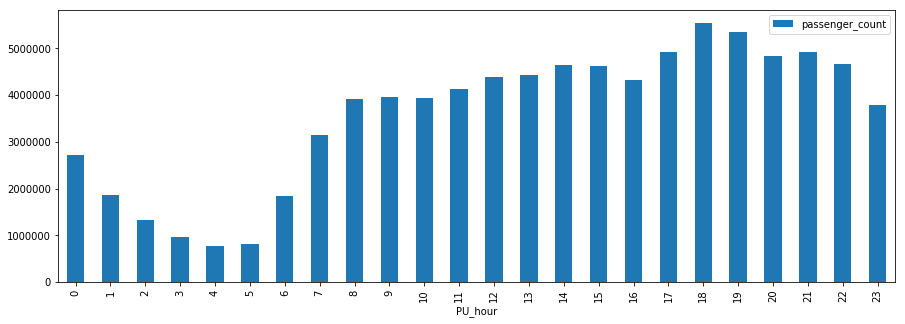

In [116]:
rq2_plot_ny(rq2_process(pd.concat([data_jan_optimized,
                                   data_feb_optimized,
                                   data_mar_optimized,
                                   data_apr_optimized,
                                   data_may_optimized,
                                   data_jun_optimized])))

In [ ]:
'''
    We notice that the most number of passengers are at 6pm,
    the lowest are 4am, and it starts increasing from 6 until 8, and it's reasonable as the working hours start,
    and it keeps increasing until reach the peak at 6pm (end of working hours and start of night life), 
    and then start decreasing until 4am
'''

passenger_count                                                     \
Borough           Bronx Brooklyn    EWR  Manhattan    Queens Staten Island   
PU_hour                                                                      
0                2800.0  71415.0    3.0  2414435.0  184910.0          35.0   
1                2354.0  51113.0    6.0  1696185.0   89160.0          32.0   
2                2001.0  38719.0    8.0  1229197.0   43171.0          27.0   
3                1811.0  30865.0    7.0   896097.0   30344.0          38.0   
4                2163.0  26942.0   33.0   680617.0   42688.0          56.0   
5                2649.0  17363.0   48.0   699731.0   76525.0          48.0   
6                4140.0  34333.0   72.0  1653455.0  128046.0          12.0   
7                6382.0  49556.0   54.0  2867234.0  179934.0          19.0   
8                5823.0  57787.0   42.0  3612801.0  193333.0          32.0   
9                4806.0  40762.0   78.0  3641725.0  219216.0          44.0   
10               4128.0  31521.0   57.0  3612170.0  246349.0          57.0   
11               3737.0  29569.0   61.0  3813006.0  222768.0          34.0   
12               3751.0  32083.0   86.0  4045625.0  245264.0          39.0   
13               3812.0  33960.0   86.0  4057777.0  264940.0          45.0   
14               3839.0  36021.0  127.0  4226475.0  309885.0          49.0   
15               4053.0  34963.0  146.0  4208647.0  316693.0          63.0   
16               3394.0  32320.0  181.0  3875978.0  344372.0          65.0   
17               4362.0  41402.0  121.0  4479012.0  328788.0          68.0   
18               3849.0  52226.0  103.0  5085123.0  316980.0          27.0   
19               3029.0  52809.0  120.0  4907374.0  313073.0          43.0   
20               2654.0  50415.0   40.0  4409759.0  316770.0          48.0   
21               3052.0  61799.0   37.0  4441246.0  339403.0          56.0   
22               3035.0  79539.0   11.0  4208748.0  299875.0          34.0   
23               3102.0  85871.0    4.0  3363873.0  281548.0          21.0   

                  
Borough  Unknown  
PU_hour           
0        34891.0  
1        24277.0  
2        17838.0  
3        13314.0  
4        10025.0  
5        10684.0  
6        23196.0  
7        38539.0  
8        47552.0  
9        48368.0  
10       48452.0  
11       51390.0  
12       56322.0  
13       59043.0  
14       63606.0  
15       64470.0  
16       61443.0  
17       69018.0  
18       74412.0  
19       71482.0  
20       64311.0  
21       65505.0  
22       60685.0  
23       49394.0

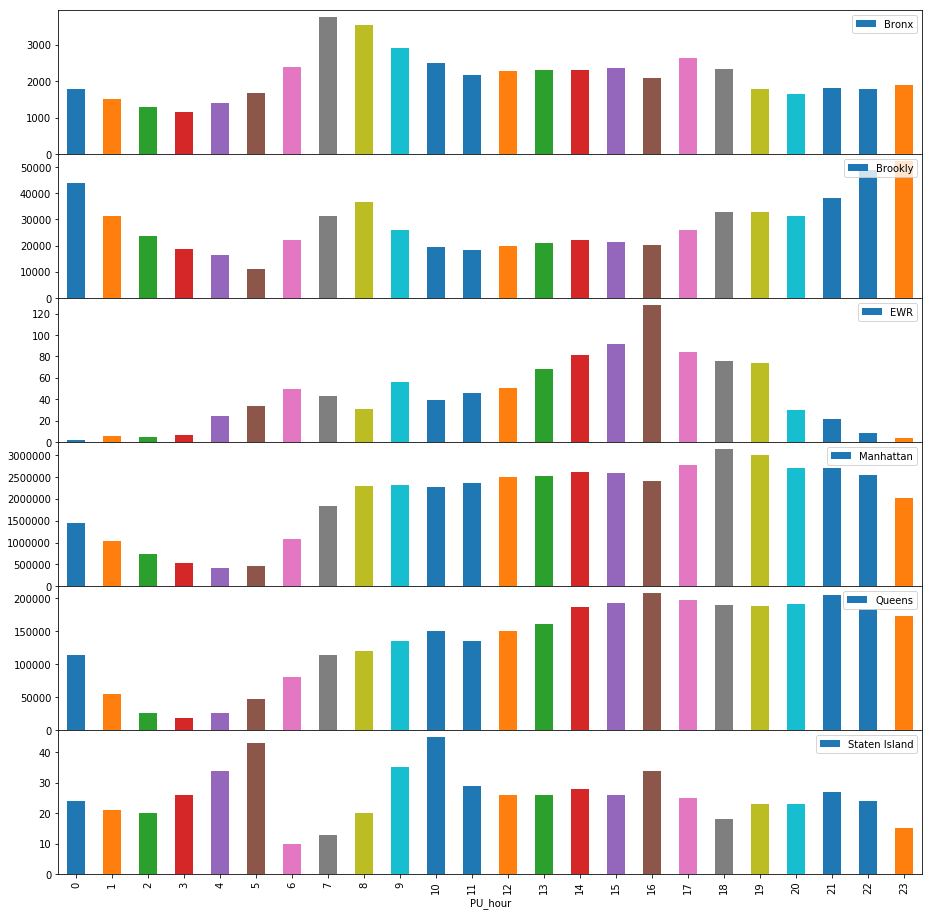

In [117]:
#rq2_plot_boroughs(rq2_process([data_jan_optimized,data_feb_optimized,data_mar_optimized,data_apr_optimized,data_may_optimized,data_jun_optimized]))
rq2_plot_boroughs(rq2_process(pd.concat([data_jan_optimized,
                                         data_feb_optimized,
                                         data_mar_optimized,
                                         data_apr_optimized,
                                         data_may_optimized,
                                         data_jun_optimized])))

In [ ]:
'''
    By visualizing data for all boroughs, we notice:
    - The differences among the boroughs in term of most passengers per slot (time of pickup)
    - Queens, Brooklyn and Manhattan have more active night life (measuring the average of taxi usage) than other boroughs
    - 
'''

In [ ]:
'''
    RQ3:
    We have to study the duration of the tips.
    
'''

In [129]:
import numpy as np
import scipy.stats as stats
import seaborn as sns

def rq3_process(df):
    rq3_ = pd.DataFrame(columns=['Duration','Borough'])
    rq3_['Borough'] = df['Borough']
    start = df['tpep_pickup_datetime']
    #end   = data_jan_optimized.at[1,'tpep_dropoff_datetime']
    end = df['tpep_dropoff_datetime']

    delta = end-start
    rq3_['Duration'] = delta.dt.seconds/60
    return (rq3_)

def rq3_polt_ny(df):
    # After running the first time we noticed very few entries with very high value in duration
    # so we are excluding them for the sake of getting better plot
    df=df[df.Duration<=60]
    fig, ax = plt.subplots(figsize=(20,7))
    plt.xticks(list(range(0,60,1)))
    sns.distplot(df['Duration'],hist=True, kde=False, 
                 bins=int(180/3), color = 'blue',
                 hist_kws={'edgecolor':'black'})
    
def rq3_plot_boroughs(df):
    # After running the first time we noticed very few entries with very high value in duration
    # so we are excluding them for the sake of getting better plot
    df=df[df.Duration<=60]
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_axes([0.1, 2.1, 0.8, 0.4])
    ax2 = fig.add_axes([0.1, 1.7, 0.8, 0.4])
    ax3 = fig.add_axes([0.1, 1.3, 0.8, 0.4])
    ax4 = fig.add_axes([0.1, 0.9, 0.8, 0.4])
    ax5 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
    ax6 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
    plt.xticks(list(range(0,60,1)))
    sns.distplot(df.loc[df['Borough'] == "Bronx"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax1, label="Bronx",hist_kws={'edgecolor':'black'});
    sns.distplot(df.loc[df['Borough'] == "Brookly"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax2, label="Brookly",hist_kws={'edgecolor':'black'});
    sns.distplot(df.loc[df['Borough'] == "EWR"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax3, label="EWR",hist_kws={'edgecolor':'black'});
    sns.distplot(df.loc[df['Borough'] == "Manhattan"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax4, label="Manhattan",hist_kws={'edgecolor':'black'});
    sns.distplot(df.loc[df['Borough'] == "Queens"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax5, label="Queens",hist_kws={'edgecolor':'black'});
    sns.distplot(df.loc[df['Borough'] == "Staten Island"]['Duration'],hist=True, kde=False, 
             bins=int(180/3), color = 'blue', ax=ax6, label="Staten Island",hist_kws={'edgecolor':'black'});


    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper right")
    ax5.legend(loc="upper right")
    ax6.legend(loc="upper right")
    return ()
    

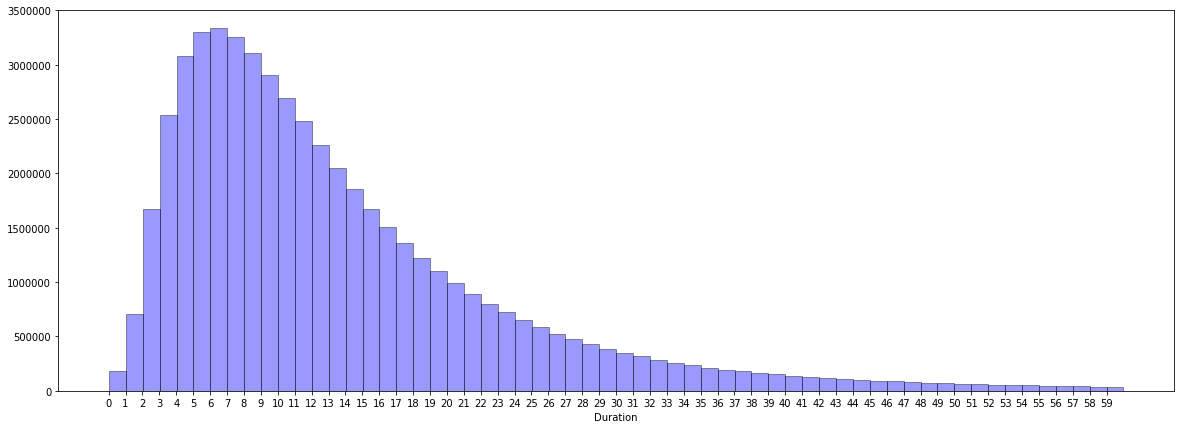

In [123]:
rq3_polt_ny(rq3_process(pd.concat([data_jan_optimized,
                                         data_feb_optimized,
                                         data_mar_optimized,
                                         data_apr_optimized,
                                         data_may_optimized,
                                         data_jun_optimized])))

In [ ]:
'''
    We notice that most of the trips last for 6 minutes
'''

()

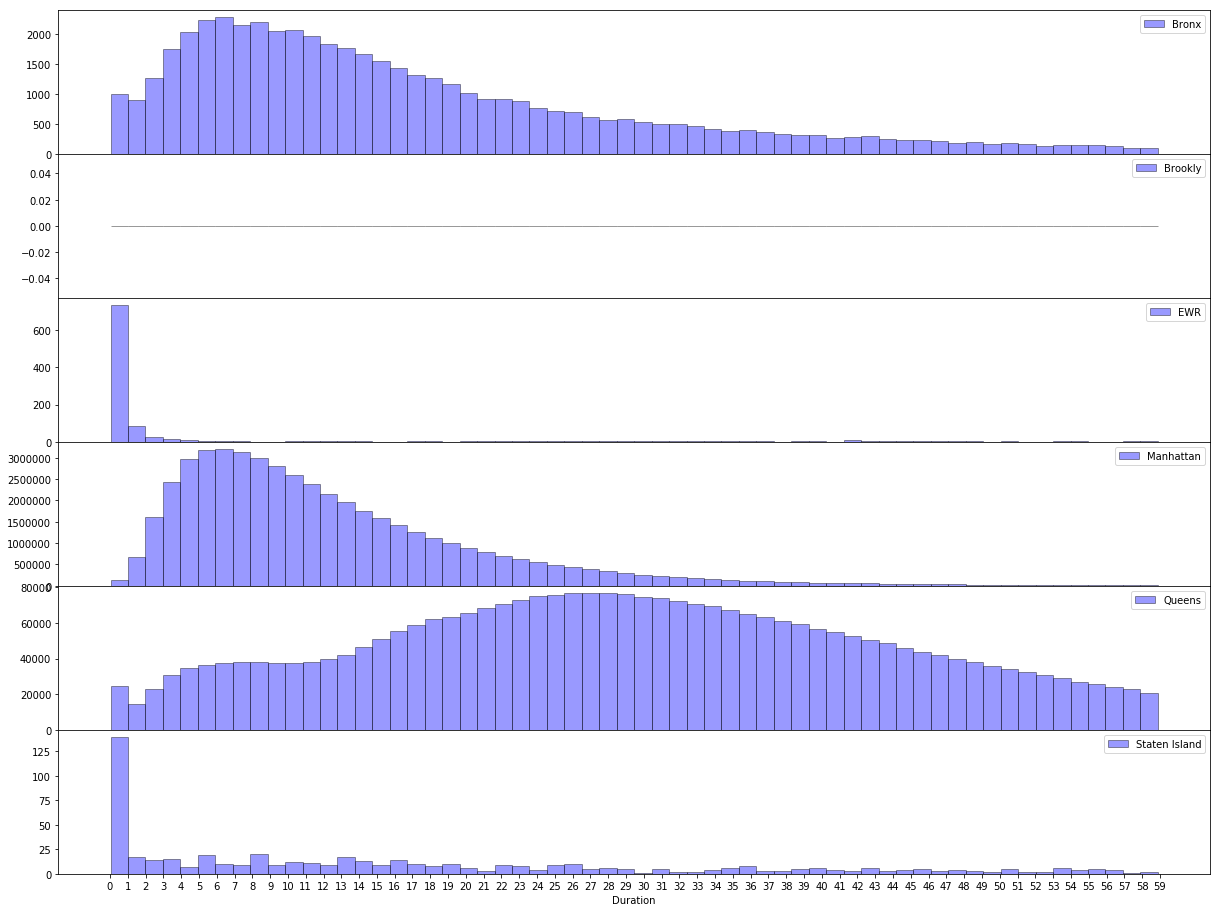

In [130]:
rq3_plot_boroughs(rq3_process(pd.concat([data_jan_optimized,
                                         data_feb_optimized,
                                         data_mar_optimized,
                                         data_apr_optimized,
                                         data_may_optimized,
                                         data_jun_optimized])))

In [ ]:
'''
    We notice the varaition of trip duration in the different boroughs:
    - Manhattan and Bronx have most of trips last for 6 minutes, but Bronx has more trips for 7-10 minutes than Manhattan
    - in Queens, most of trips long more the others, tends to 27-28 minutes (longer trips in term of duration) 
      To validate the results:
      we checked Queens map and some other information, we learnd that Queens is one of the largest urban centers in US,  
      and it has less population than Manhattan, also it has two important airports, 
      all these info support the idea that it has the longest trips in average which totally agrees with our results.
    - in State Island and EWR, very short trips, 1 minute.
'''

In [ ]:
'''
    RQ4:
    Analysing the method of payment.
    We only  need two column of our data: payment_type and Borough
    
'''

In [156]:
import matplotlib.gridspec as gridspec
def rq4_process(df):
    rq4_= df[['payment_type','Borough']].groupby(['payment_type','Borough']).size().unstack()
    # we change the index from integer to the name of the method
    rq4_.index = ['Credit Card','Cash', 'No Charge', 'Dispute']
    # drop the row of 'No Charge', since we don't need to analyze
    rq4_ = rq4_.drop('No Charge')
    # drop the column of 'Unkown'
    rq4_ = rq4_.drop('Unknown', 1)
    
    return (rq4_)
    
def rq4_plot(df):
    fig = plt.figure(constrained_layout=True,figsize=(15, 8))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])
    ax3 = fig.add_subplot(spec[0, 2])
    ax4 = fig.add_subplot(spec[1, 0])
    ax5 = fig.add_subplot(spec[1, 1])
    ax6 = fig.add_subplot(spec[1, 2])
    
    df.iloc[:,0].plot(ax=ax1, kind='bar', label='Bronx', rot=0)
    df.iloc[:,1].plot(ax=ax2, kind='bar', label='Brooklyn', rot=0)
    df.iloc[:,2].plot(ax=ax3, kind='bar', label='EWR', rot=0)
    df.iloc[:,3].plot(ax=ax4, kind='bar', label='Manhattan', rot=0)
    df.iloc[:,4].plot(ax=ax5, kind='bar', label='Queens', rot=0)
    df.iloc[:,5].plot(ax=ax6, kind='bar', label='Staten Island', rot=0)
    
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax4.legend(loc="upper right")
    ax5.legend(loc="upper right")
    ax6.legend(loc="upper right")
    
    return()


    

In [158]:
# We create this dataframe, so we can use later on in chi-square test
rq4_df = rq4_process(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized]))

In [159]:
rq4_df

Borough,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
Credit Card,26591,434423,840,33877114,2270182,319
Cash,23893,224359,164,14294865,953116,273
Dispute,169,1365,10,50586,6226,4


()

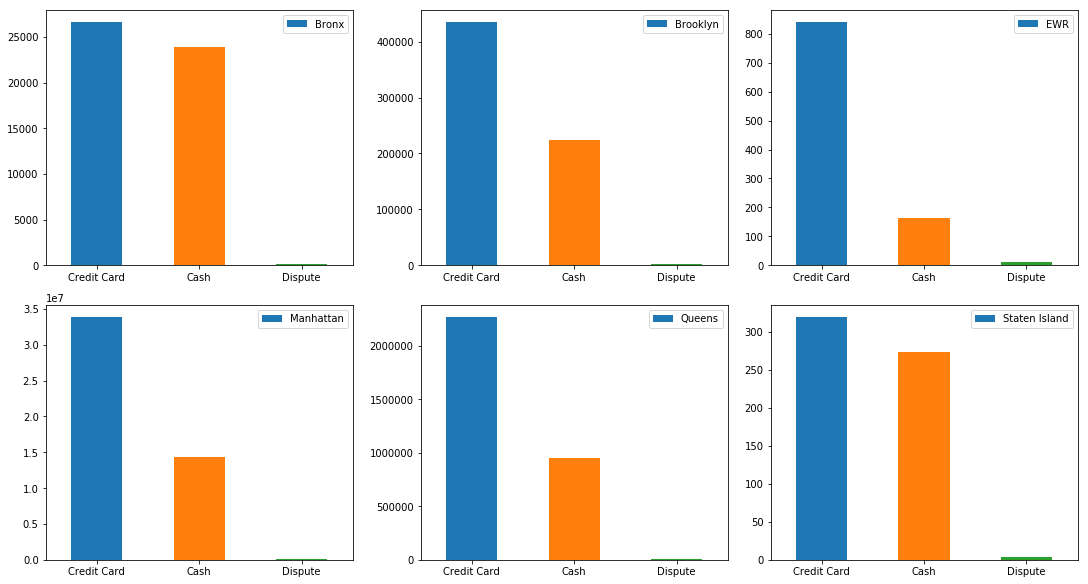

In [160]:
rq4_plot(rq4_df)

In [ ]:
'''
    We can notice that payment with Credit Card is the dominating method in 4 boroughs, the other two Credit and Cash are close.
    We will check by chi-square if there's any kind of relations between borough and method of payment
'''

In [203]:
# we add total column and total row to the above table to get the contengincy table
rq4_contengincy = rq4_df.copy()
# it is not possible to append column to this df normally due to the categorical Index, so we had to look for workaround
rq4_contengincy.loc['All'] = rq4_contengincy.sum()
rq4_contengincy.columns = pd.CategoricalIndex(rq4_contengincy.columns).add_categories(['All'])
rq4_contengincy['All'] = rq4_contengincy.sum(axis=1)
rq4_contengincy

Borough,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island,All
Credit Card,26591,434423,840,33877114,2270182,319,36609469
Cash,23893,224359,164,14294865,953116,273,15496670
Dispute,169,1365,10,50586,6226,4,58360
All,50653,660147,1014,48222565,3229524,596,52164499


In [212]:

rq4_obs = np.array([rq4_contengincy.iloc[0][0:6].values,
                  rq4_contengincy.iloc[1][0:6].values,
                  rq4_contengincy.iloc[2][0:6].values,])
rq4_obs

array([[   26591,   434423,      840, 33877114,  2270182,      319],
       [   23893,   224359,      164, 14294865,   953116,      273],
       [     169,     1365,       10,    50586,     6226,        4]])

In [214]:
from scipy import stats
stats.chi2_contingency(rq4_obs)[0:3]

(16572.933744454633, 0.0, 10)

In [ ]:
'''
    With degree of freedom =10
    the chi-square is too high, and the p-value will be approximately zero.
    so we have statistical eviedence against the H0, and there's kind of relation between the borough and the payment method.
     
'''

In [215]:
# removing rq4 from memory:
del rq4_obs
del rq4_contengincy
del rq4_plot

In [ ]:
'''
    RQ5:
    Analysing the correlation between trip distance and duration.
    
'''

In [363]:
def rq5_process(df):
    
    
    rq5_ = pd.DataFrame(columns=['Duration','Distance'])
    rq5_['Distance'] = df['trip_distance']
    start = df['tpep_pickup_datetime']
    end = df['tpep_dropoff_datetime']

    delta = end-start
    rq5_['Duration'] = delta.dt.seconds/60
    
    #rq5_ = rq5_[rq5_.Duration<60].sample(1000)

    # we observed some duration values = 0, and some negative Distance, we cleanse the data: 
    rq5_ = rq5_[rq5_.Duration>0]
    rq5_ = rq5_[rq5_.Distance>0]
    
    rq5_=rq5_.sort_values('Distance')
    
    return(rq5_)

def rq5_plot(df):
    #fig, ax = plt.figure(figsize=(20, 8))
    #plt.plot(df['Distance'], kind='bar')
    fig, ax = plt.subplots(figsize=(20,7))

    df=df.sort_values('Distance')
    #df['Duration'].plot(ax=ax, kind='bar')
    
    x = np.arange(1000)
    plt.plot(x, df['Distance'])
    plt.plot(x, df['Duration'])
    #df['Duration'].plot(ax=ax, kind='line')
    #df['Distance'].plot(ax=ax, kind='line')
    #df.plot(ax=ax, x='Duration', y='Distance',kind='scatter')
    return()
def rq5_plot_disc(df):
    #fig, ax = plt.figure(figsize=(20, 8))
    #plt.plot(df['Distance'], kind='bar')
    fig, ax = plt.subplots(figsize=(20,7))
    df.plot(ax=ax, kind='line')
    #df=df.sort_values('Distance')
    #df['Duration'].plot(ax=ax, kind='bar')
    
    #x = np.arange(1000)
    #plt.plot(x, df['Distance'])
    #plt.plot(x, df['Duration'])
    #df['Duration'].plot(ax=ax, kind='line')
    #df['Distance'].plot(ax=ax, kind='line')
    #df.plot(ax=ax, x='Duration', y='Distance',kind='scatter')
    return()

def rq5_process_sample(df):
    
    
    rq5_ = pd.DataFrame(columns=['Duration','Distance'])
    rq5_['Distance'] = df['trip_distance']
    start = df['tpep_pickup_datetime']
    end = df['tpep_dropoff_datetime']

    delta = end-start
    rq5_['Duration'] = delta.dt.seconds/60
    
    rq5_sample = rq5_[rq5_.Duration<60].sample(1000)

    # we observed some duration values = 0, and some negative Distance, we cleanse the data: 
    rq5_sample = rq5_sample[rq5_sample.Duration>0]
    rq5_sample = rq5_sample[rq5_sample.Distance>0]
    
    rq5_sample=rq5_sample.sort_values('Distance')
    
    return(rq5_sample)

def rq5_process_discrete(df):
    
    
    rq5_ = pd.DataFrame(columns=['Duration','Distance'])
    # we convert distance to discrete values in order to group them and take average of duration
    rq5_['Distance'] = df['trip_distance'].apply(lambda x: int(x/10))
    
    start = df['tpep_pickup_datetime']
    end = df['tpep_dropoff_datetime']

    delta = end-start
    rq5_['Duration'] = delta.dt.seconds/60
    
    #rq5_sample = rq5_[rq5_.Duration<60].sample(1000)

    # we observed some duration values = 0, and some negative Distance, we cleanse the data: 
    rq5_ = rq5_[rq5_.Duration>0]
    rq5_ = rq5_[rq5_.Distance>0]
    
    rq5_disc = rq5_[['Distance','Duration']].groupby('Distance').mean()
    
    rq5_disc=rq5_disc.sort_values('Distance')
    
    return(rq5_disc)

In [ ]:
rq5_plot(rq5_process(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized])))

In [311]:
rq5_sample = rq5_process(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized]))

()

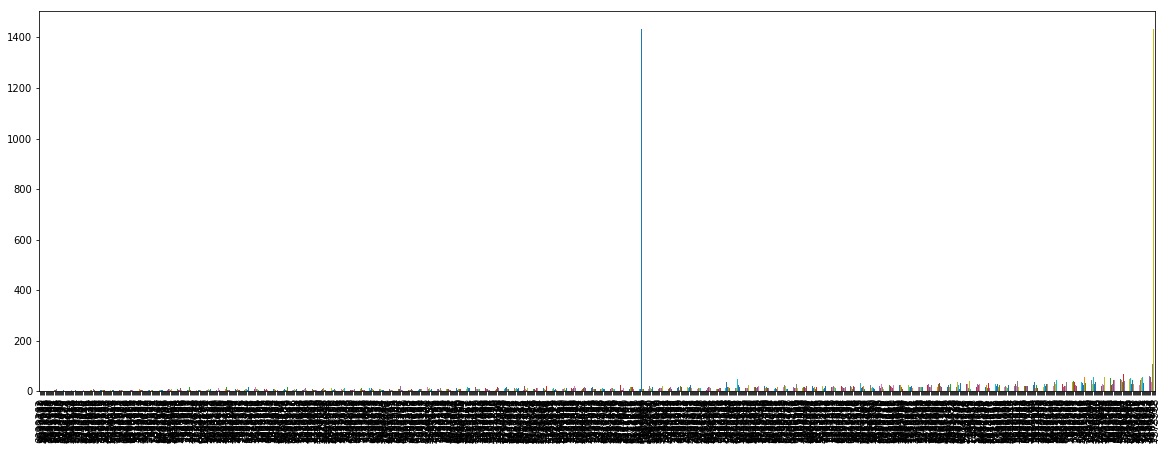

In [278]:
# plotting all data before taking 1000 samples
rq5_plot(rq5_sample)

In [ ]:
# from the plot above we notice that we need to ..

()

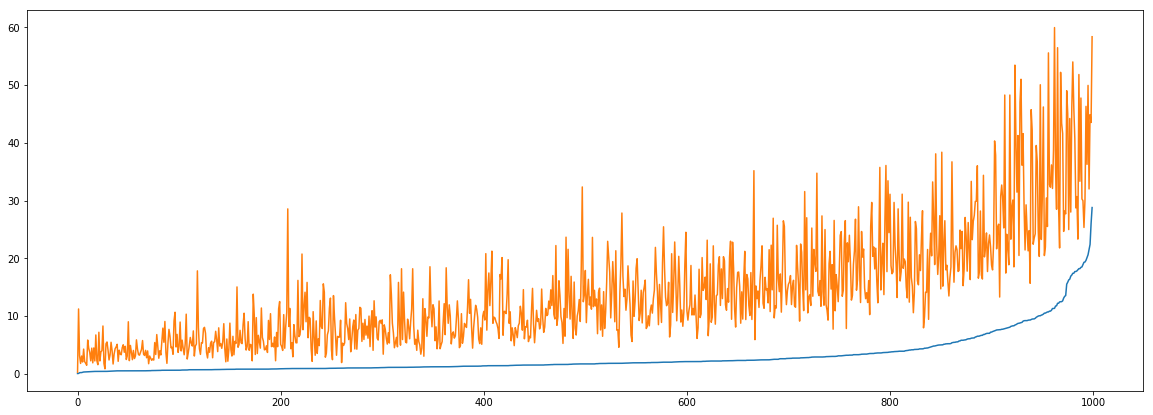

In [312]:
# plotting only 1000 random samples
rq5_process_sample(rq5_sample)

In [ ]:
'''
    We notice that when the increament of Duration is not 
'''

In [357]:
rq5_data_disc = rq5_process_discrete(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized]))

In [350]:
rq5_data_disc.head()

,Duration
Distance,
1,12.726335
2,18.178397
3,22.476662
4,25.250302
5,27.358831


In [368]:
rq5_data_disc.describe()

,Duration
count,36.000000
mean,180.266714
std,169.816804
min,0.050000
25%,56.357261
50%,147.685222
75%,227.913542
max,674.550000


()

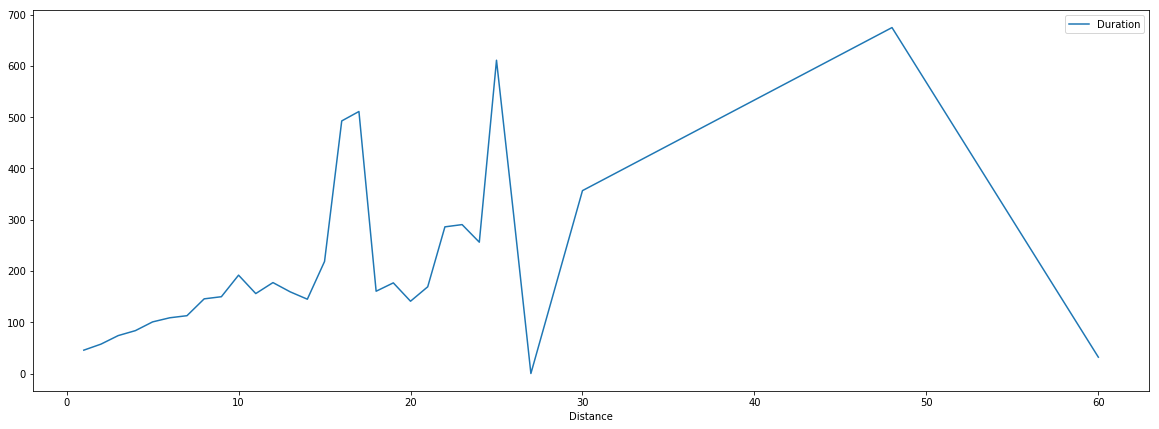

In [374]:
rq5_plot_disc(rq5_data_disc[:30])

()

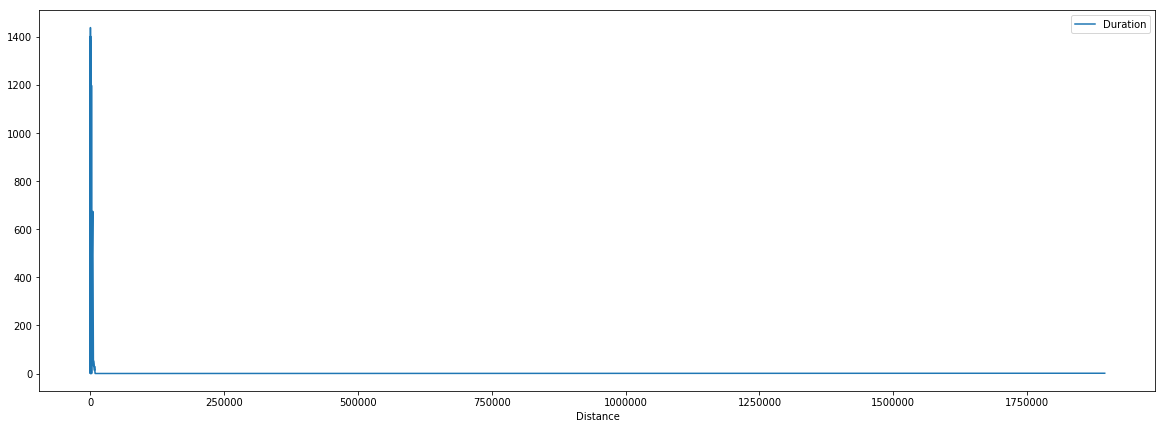

In [328]:
rq5_plot_disc(rq5_process_discrete(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized])))

In [365]:
rq5_data =rq5_process(pd.concat([data_jan_optimized,
                                data_feb_optimized,
                                data_mar_optimized,
                                data_apr_optimized,
                                data_may_optimized,
                                data_jun_optimized]))


In [378]:
np.corrcoef(rq5_data['Distance'], rq5_data['Duration'])[0, 1]

0.022475034067917805

In [380]:
from scipy.stats.stats import pearsonr 
pearsonr(rq5_data['Distance'], rq5_data['Duration'])

(0.022475034426062898, 0.0)

In [ ]:
'''
    Wit p-value = 0.0, we see that there's a significant relation between distance and duration
    But with the Pearson correlation coefficient a small positive value,
    we conclude that this relation is a weak positive relation
'''

In [ ]:
'''
    CRQ1
'''

In [382]:
data = pd.concat([data_jan_optimized,
                                    data_feb_optimized,
                                    data_mar_optimized,
                                    data_apr_optimized,
                                    data_may_optimized,
                                    data_jun_optimized])



In [435]:
data = data[['tpep_pickup_datetime','tpep_dropoff_datetime','total_amount','trip_distance','Borough']]

In [436]:
cq1_data = pd.DataFrame(columns=['price_per_mile','weighted_price_per_mile','Borough'])


In [437]:
cq1_data['Borough'] = data['Borough']


In [438]:
cq1_data['price_per_mile']=(data.total_amount/data.trip_distance)


In [440]:
#start = data['tpep_pickup_datetime']
#end = data['tpep_dropoff_datetime']
delta = (data['tpep_dropoff_datetime']-data['tpep_pickup_datetime']).dt.seconds
cq1_data['weighted_price_per_mile']=cq1_data.price_per_mile/delta


cq1_data=cq1_data[cq1_data.price_per_mile>0]


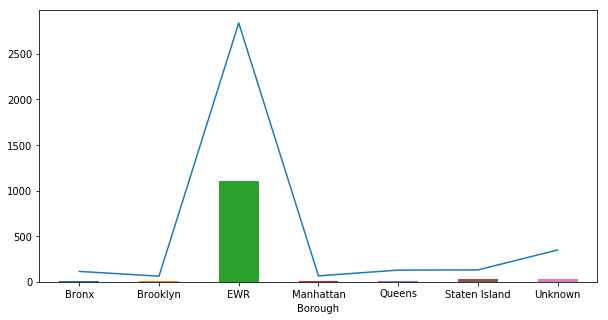

In [447]:
mean_1=cq1_data.groupby('Borough')['price_per_mile'].mean()
std_1=cq1_data.groupby('Borough')['price_per_mile'].std()
#mean_1
#std_1
fig, ax = plt.subplots(figsize=(10,5))

mean_1.plot(ax=ax, kind='bar')
std_1.plot(ax=ax, kind='line')

In [ ]:
'''
    We notice that trips the average cost (cost per mile) of taxi service in EWR is higher than other boroughs
     But it tends to be equal in all other boroughs
'''

In [566]:
# Now we perform T-test on each borough to calculate the p value:
# For Bronx;
from scipy.stats import ttest_ind
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Bronx'])
print('Bronx Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Brooklyn'])
print('Brooklyn Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='EWR'])
print('EWR Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Manhattan'])
print('Manhattan Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Queens'])
print('Queens Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Staten Island'])
print('Staten Island Statistics={}, p={}'.format(b_s,b_p))

Bronx Statistics=-4.318478878150374, p=1.571085379505739e-05
Brooklyn Statistics=12.120154277653494, p=8.261189204532079e-34
EWR Statistics=-423.9013298350705, p=0.0
Manhattan Statistics=18.67596404432217, p=7.769815967720425e-78
Queens Statistics=10.426519986756942, p=1.8764490132961256e-25
Staten Island Statistics=-7.611403211984099, p=2.7114033576134576e-14


In [ ]:
'''
    From the p-values above, and by considering alpha=0.05, we notice that we reject the H0 for all boroughs compairing to NY
    
'''

In [ ]:
'''
    We will perform some paired T-test among the boroughs to verify the conclusion above
'''

In [605]:
alpha = 0.05
def doPairTest(b1,b2):
    b_s, b_p = ttest_ind(cq1_data['price_per_mile'][cq1_data.Borough==b1],cq1_data['price_per_mile'][cq1_data.Borough==b2])

    if b_p > alpha:
        print('Same distribution between {} and {} with p-value = {}.'.format(b1,b2,b_p))
    else:
        print('Different distribution between {} and {} with p-value = {}.'.format(b1,b2,b_p))

doPairTest('Manhattan','Brooklyn')
doPairTest('Brooklyn','Bronx')
doPairTest('Staten Island','EWR')
doPairTest('Manhattan','Bronx')
doPairTest('Brooklyn','Queens')


Different distribution between Manhattan and Brooklyn with p-value = 8.828064391005463e-33.
Different distribution between Brooklyn and Bronx with p-value = 2.171301251808764e-20.
Different distribution between Staten Island and EWR with p-value = 2.839139416172804e-20.
Different distribution between Manhattan and Bronx with p-value = 1.0502144165330045e-10.
Different distribution between Brooklyn and Queens with p-value = 6.3833000399884775e-06.


In [602]:
# Now we perform T-test on each borough to calculate the p value:
# For Bronx;
from scipy.stats import ttest_ind
b_s, b_p=ttest_ind(cq1_data['weighted_price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Bronx'])
print('Bronx Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Brooklyn'])
print('Brooklyn Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='EWR'])
print('EWR Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Manhattan'])
print('Manhattan Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Queens'])
print('Queens Statistics={}, p={}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Staten Island'])
print('Staten Island Statistics={}, p={}'.format(b_s,b_p))

Bronx Statistics=-8.657187052021358, p=4.835621358930186e-18
Brooklyn Statistics=97.69110656202231, p=0.0
EWR Statistics=-77.38286189164306, p=0.0
Manhattan Statistics=833.639317988736, p=0.0
Queens Statistics=208.7518999931394, p=0.0
Staten Island Statistics=2.349428215078704, p=0.018802272940517586


In [581]:
# by removing Unknown 
cq1_data=cq1_data[cq1_data.Borough!='Unknown']

In [597]:
b_s, b_p=ttest_ind(cq1_data['price_per_mile'][cq1_data.Borough=='Bronx'],cq1_data['price_per_mile'])
print('Bronx Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Brooklyn'])
print('Brooklyn Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='EWR'])
print('EWR Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'][cq1_data.Borough=='Manhattan'],cq1_data['price_per_mile'])
print('Manhattan Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Queens'])
print('Queens Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['price_per_mile'][cq1_data.Borough=='Staten Island'])
print('Staten Island Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))

Bronx Statistics=5.856, p=0.000
Brooklyn Statistics=10.779, p=0.000
EWR Statistics=-486.561, p=0.000
Manhattan Statistics=0.181, p=0.857
Queens Statistics=5.324, p=0.000
Staten Island Statistics=-8.865, p=0.000


In [ ]:
'''
    After removing entries with unknown borough, we found that Manhattan has a p-value>alpha
    which means the distribution is equal to New York 
'''

In [599]:
b_s, b_p=ttest_ind(cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Bronx'],cq1_data['weighted_price_per_mile'])
print('Bronx Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Brooklyn'])
print('Brooklyn Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='EWR'])
print('EWR Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'][cq1_data.Borough=='Manhattan'],cq1_data['weighted_price_per_mile'])
print('Manhattan Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Queens'])
print('Queens Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))
b_s, b_p=ttest_ind(cq1_data['price_per_mile'],cq1_data['weighted_price_per_mile'][cq1_data.Borough=='Staten Island'])
print('Staten Island Statistics={0:.3f}, p={1:.3f}'.format(b_s,b_p))

Bronx Statistics=8.657, p=0.000
Brooklyn Statistics=97.691, p=0.000
EWR Statistics=-77.383, p=0.000
Manhattan Statistics=948.498, p=0.000
Queens Statistics=208.752, p=0.000
Staten Island Statistics=2.349, p=0.019


In [603]:
def doPairTestW(b1,b2):
    b_s, b_p = ttest_ind(cq1_data['weighted_price_per_mile'][cq1_data.Borough==b1],cq1_data['weighted_price_per_mile'][cq1_data.Borough==b2])

    if b_p > alpha:
        print('Same distribution between {} and {} with p-value = {}.'.format(b1,b2,b_p))
    else:
        print('Different distribution between {} and {} with p-value = {}.'.format(b1,b2,b_p))

doPairTestW('Manhattan','Queens')
doPairTestW('Brooklyn','Bronx')
doPairTestW('Staten Island','EWR')
doPairTestW('Manhattan','Bronx')
doPairTestW('Brooklyn','Queens')

Different distribution between Manhattan and Queens with p-value = 0.0.
Different distribution between Brooklyn and Bronx with p-value = 6.028844830593536e-13.
Different distribution between Staten Island and EWR with p-value = 4.143929991939019e-09.
Different distribution between Manhattan and Bronx with p-value = 3.0144424573609726e-30.
Different distribution between Brooklyn and Queens with p-value = 5.807615190920361e-21.


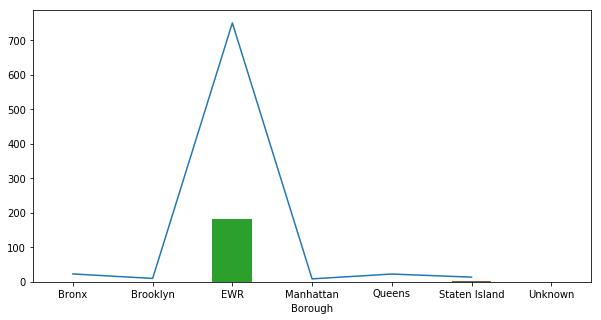

In [604]:
mean_2=cq1_data.groupby('Borough')['weighted_price_per_mile'].mean()
std_2=cq1_data.groupby('Borough')['weighted_price_per_mile'].std()
count_2 = cq1_data.groupby('Borough')['weighted_price_per_mile'].count()

fig, ax = plt.subplots(figsize=(10,5))

mean_2.plot(ax=ax, kind='bar')
std_2.plot(ax=ax, kind='line')

In [ ]:
'''
    We can notice for the weighted price, that the distribution is different among boroughs
'''

In [ ]:
'''
    By comparing the results above:
    we found that with the weighted price, we noticed that Manhattan distribution is similar to NY distribution,
    and this is reasonable due to the fact that majority of the trips recorded are in Manhattan
'''

In [ ]:
'''
    CRQ2:
    
'''

In [608]:
import folium
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import branca.colormap as cm
%matplotlib inline

In [611]:
data = pd.concat([data_jan_optimized,
                                    data_feb_optimized,
                                    data_mar_optimized,
                                    data_apr_optimized,
                                    data_may_optimized,
                                    data_jun_optimized])

In [612]:
#Group data by pick up and drop off locations
PUDic=data.groupby("PULocationID")['passenger_count'].sum()
DODic=data.groupby("DOLocationID")['passenger_count'].sum()

In [613]:
#Creating Linear Colormap for pick up and drop off location depending on the min and max values of each group 
linearPU = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=min(PUDic), vmax=max(PUDic),
    caption="Pick Up Pessengers"
)
linearDO = cm.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=min(DODic), vmax=max(DODic),
    caption="Drop off Pessengers"
)


In [614]:
#loading taxi zones data
zones = os.path.join('taxi_zones.json')
geo_json_data = json.load(open(zones))

In [615]:
#merging taxi zones data with the number of pick up and drop off passengers 
for i in geo_json_data["features"]:
    
    i['properties']["PassengersPU"]=int(PUDic[i['properties']['LocationID']] if (i['properties']['LocationID'] in PUDic) else 0)
    i['properties']["PassengersDO"]=int(DODic[i['properties']['LocationID']] if (i['properties']['LocationID'] in DODic) else 0)
    

In [ ]:
#drawing map of location with data of pick up passengers
m = folium.Map([40.7831, -73.9712], tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda properties: {
        'fillColor': linearPU(properties['properties']['PassengersPU']),
        #'fillColor': print(properties['properties']['LocationID']),
        'color': 'black',
        'weight': 1,
    },
    tooltip= folium.features.GeoJsonTooltip(fields=['zone','borough','PassengersPU'],aliases=['Zone','Borough','Pick up Passengers'])
).add_to(m)
m.add_child(linearPU)
m.save('PickUpMap.html')

In [ ]:
#drawing map of location with data of drop off passengers
m2 = folium.Map([40.7831, -73.9712], tiles='cartodbpositron', zoom_start=10)
folium.GeoJson(
    geo_json_data,
    style_function=lambda properties: {
        'fillColor': linearDO(properties['properties']['PassengersDO']),
        #'fillColor': print(properties['properties']['LocationID']),
        'color': 'black',
        'weight': 1,
    },
    tooltip= folium.features.GeoJsonTooltip(fields=['zone','borough','PassengersDO'],aliases=['Zone','Borough','Drop off Passengers'])
).add_to(m2)
m2.add_child(linearDO)
m2.save('DropOffMap.html')